In [2]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input,Dropout,Dense
from keras.models import Model
from keras import regularizers
from keras.utils.data_utils import get_file
from sklearn import metrics
%matplotlib inline

# Loading the data
The UNSW_NB15 dataset is available in a github __[repository](https://github.com/99-dinesh/IDS/tree/main)__, we will be using the following files
- __[UNSW_NB15Train1.csv](https://github.com/99-dinesh/IDS/blob/main/UNSW_NB15_training-set1.csv)__ for training the model.
- __[UNSW_NB15Train2.csv](hhttps://github.com/99-dinesh/IDS/blob/main/UNSW_NB15_training-set2.csv)__ for training the model.
- __[UNSW_NB15Test.csv](https://github.com/99-dinesh/IDS/blob/main/UNSW_NB15_testing-set.csv)__ for testing.

We will use the utility function `get_file` from keras to download the files and we'll read them into a pandas dataframe afterward.

In [79]:
# Downloading training and test sets to local drive
try:
    training_set_path1 = get_file('UNSW_NB15Train%2B.csv', origin='https://raw.githubusercontent.com/99-dinesh/IDS/main/UNSW_NB15_training-set1.csv')
    training_set_path2=get_file('UNSW_NB15Train%2B.csv',origin='https://raw.githubusercontent.com/99-dinesh/IDS/main/UNSW_NB15_training-set2.csv')
except:
    print('Error downloading')
    raise
    

try:
    test_set_path = get_file('UNSW_NB15Test%2B.csv', origin='https://raw.githubusercontent.com/99-dinesh/IDS/main/UNSW_NB15_testing-set.csv')
except:
    print('Error downloading')
    raise
training_df1 = pd.read_csv(training_set_path1, header=None)
training_df2 = pd.read_csv(training_set_path2, header=None)
testing_df = pd.read_csv(test_set_path, header=None)


In [80]:
training_df1=training_df1.drop(0,axis=1)
training_df2=training_df2.drop(0,axis=1,)

Next we'll take a look at the dataframes :

In [81]:
training_df1=training_df1.loc[1:,:]
training_df1.head()

training_df2=training_df2.loc[1:,:]
training_df2.head()

testing_df=testing_df.loc[1:,:]
testing_df.head()


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
1,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
2,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
3,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
4,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
5,5,0.00001,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [82]:
training_df1.head(5)

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
1,1,0.121478,tcp,-,FIN,6,4,258,172,74.08749,...,1,1,0,0,0,1,1,0,Normal,0
2,2,0.6499020000000001,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
3,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170160999999998,...,1,3,0,0,0,2,6,0,Normal,0
4,4,1.6816419999999999,tcp,ftp,FIN,12,12,628,770,13.677107999999999,...,1,3,1,1,0,2,1,0,Normal,0
5,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [83]:
training_df2.head(5)

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
1,1,0.121478,tcp,-,FIN,6,4,258,172,74.08749,...,1,1,0,0,0,1,1,0,Normal,0
2,2,0.6499020000000001,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
3,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170160999999998,...,1,3,0,0,0,2,6,0,Normal,0
4,4,1.6816419999999999,tcp,ftp,FIN,12,12,628,770,13.677107999999999,...,1,3,1,1,0,2,1,0,Normal,0
5,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [84]:
testing_df.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
1,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
2,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
3,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
4,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
5,5,0.00001,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


Since the CSV files don't contain a header we'll need to assign column names ourselves.

In [85]:
 columns = [
    'id',
     'dur',
     'proto',
     'service',
     'state',
     'spkts',
     'dpkts',
     'sbytes',
     'dbytes',
     'rate',
     'sttl',
     'dttl',
     'sload',
     'dload',
     'sloss',
     'dloss',
     'sinpkt',
     'dinpkt',
     'sjit',
     'djit',
     'swin',
     'stcpb',
     'dtcpb',
     'dwin',
     'tcprtt',
     'synack',
     'ackdat',
     'smean',
     'dmean',
     'trans_depth',
     'response_body_len',
     'ct_srv_src',
     'ct_state_ttl',
     'ct_dst_ltm',
     'ct_src_dport_ltm',
     'ct_dst_sport_ltm',
     'ct_dst_src_ltm',
     'is_ftp_login',
     'ct_ftp_cmd',
     'ct_flw_http_mthd',
     'ct_src_ltm',
     'ct_srv_dst',
     'is_sm_ips_ports',
     'attack_cat',
     'label'
]
training_df1.columns = columns
training_df2.columns = columns
testing_df.columns = columns

In [86]:
training_df=pd.concat([training_df1,training_df2])
training_df.shape

(175342, 45)

In [87]:
training_df['attack_cat'].value_counts()
testing_df['attack_cat'].value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

Now that we've assigned names to the columns let's take a deeper look into the data.

In [88]:
print("Training set1 has {} rows.".format(len(training_df)))
print("Testing set has {} rows.".format(len(testing_df)))

Training set1 has 175342 rows.
Testing set has 82332 rows.


In [89]:
training_outcomes=training_df['attack_cat'].unique()
testing_outcomes=testing_df['attack_cat'].unique()
print("The training set has {} possible outcomes \n".format(len(training_outcomes)) )
print(", ".join(training_outcomes)+".")
print("\nThe testing set has {} possible outcomes \n".format(len(testing_outcomes)))
print(", ".join(testing_outcomes)+".")

The training set has 9 possible outcomes 

Normal, Backdoor, Analysis, Fuzzers, Shellcode, Reconnaissance, Exploits, DoS, Worms.

The testing set has 10 possible outcomes 

Normal, Reconnaissance, Backdoor, DoS, Exploits, Analysis, Fuzzers, Worms, Shellcode, Generic.


In [90]:
# A list ot attack names that belong to each general attack type
Combined_attacks=['Backdoor','Analysis','Shellcode','Worms']

# Our new labels
classes=["Normal","Combined_attacks","DoS","Exploits","Fuzzers","Reconnaissance","Generic"]

#Helper function to label samples to 5 classes
def label_attack (row):
    if row["attack_cat"] in Combined_attacks:
        return classes[1]
    if row["attack_cat"] == "DoS":
        return classes[2]
    if row["attack_cat"] == "Exploits":
        return classes[3]
    if row["attack_cat"] == "Fuzzers" :
        return classes[4]
    if row["attack_cat"] == "Reconnaissance" :
        return classes[5]
    if row["attack_cat"] == "Generic" :
        return classes[6]
    return classes[0]


#We combine the datasets temporarily to do the labeling 
test_samples_length = len(testing_df)
df=pd.concat([training_df,testing_df])
df["Class"]=df.apply(label_attack,axis=1)


# The old outcome field is dropped since it was replaced with the Class field, the difficulty field will be dropped as well.
df=df.drop("attack_cat",axis=1)
df=df.drop("label",axis=1)

# we again split the data into training and test sets.
training_df= df.iloc[:-test_samples_length, :]
testing_df= df.iloc[-test_samples_length:,:]


Let's take a look at the new labels 

In [91]:
training_outcomes=training_df["Class"].unique()
testing_outcomes=testing_df["Class"].unique()
print("The training set has {} possible outcomes \n".format(len(training_outcomes)) )
print(", ".join(training_outcomes)+".")
print("\nThe testing set has {} possible outcomes \n".format(len(testing_outcomes)))
print(", ".join(testing_outcomes)+".")

The training set has 6 possible outcomes 

Normal, Combined_attacks, Fuzzers, Reconnaissance, Exploits, DoS.

The testing set has 7 possible outcomes 

Normal, Reconnaissance, Combined_attacks, DoS, Exploits, Fuzzers, Generic.


## Preparing the Features

For continuous features we use the `MinMaxScaler` provided by the scikit-learn library, we only allow the scaler to fit the training set values and then we use it to scale both the training and testing sets. The `minmax_scale_values` helper function does this task.

As for the discrete features we use one hot encoding. The `encode_text` function achieves this.

In [92]:
# Helper function for scaling continous values
def minmax_scale_values(training_df,testing_df, col_name):
    scaler = MinMaxScaler()
    scaler = scaler.fit(training_df[col_name].values.reshape(-1, 1))
    train_values_standardized = scaler.transform(training_df[col_name].values.reshape(-1, 1))
    training_df[col_name] = train_values_standardized
    test_values_standardized = scaler.transform(testing_df[col_name].values.reshape(-1, 1))
    testing_df[col_name] = test_values_standardized
    
    
#Helper function for one hot encoding
def encode_text(training_df,testing_df, name):
    training_set_dummies = pd.get_dummies(training_df[name])
    testing_set_dummies = pd.get_dummies(testing_df[name])
    for x in training_set_dummies.columns:
        dummy_name = "{}_{}".format(name, x)
        training_df[dummy_name] = training_set_dummies[x]
        if x in testing_set_dummies.columns :
            testing_df[dummy_name]=testing_set_dummies[x]
        else :
            testing_df[dummy_name]=np.zeros(len(testing_df))
    training_df.drop(name, axis=1, inplace=True)
    testing_df.drop(name, axis=1, inplace=True)
    
    
sympolic_columns=["proto","service","state"]
label_column="Class"
for column in df.columns :
    if column in sympolic_columns:
        encode_text(training_df,testing_df,column)
    elif not column == label_column:
        minmax_scale_values(training_df,testing_df, column)

In [93]:
training_df.head(5)

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
1,0.000000,0.002025,0.000527,0.000364,0.000018,0.000012,0.000074,0.988235,1.000000,2.364553e-06,...,0,0,0,1,0,0,0,0,0,0
2,0.000011,0.010832,0.001370,0.003463,0.000056,0.002867,0.000078,0.243137,0.992126,1.401989e-06,...,0,0,0,1,0,0,0,0,0,0
3,0.000023,0.027052,0.000738,0.001458,0.000027,0.000900,0.000014,0.243137,0.992126,2.625704e-07,...,0,0,0,1,0,0,0,0,0,0
4,0.000034,0.028027,0.001159,0.001093,0.000048,0.000053,0.000014,0.243137,0.992126,4.576117e-07,...,0,0,0,1,0,0,0,0,0,0
5,0.000046,0.007491,0.000948,0.000547,0.000040,0.000018,0.000033,0.996078,0.992126,1.429776e-06,...,0,0,0,1,0,0,0,0,0,0


In [94]:
testing_df.head(5)

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
1,0.000000,1.833334e-07,0.000105,0.0,0.000037,0.0,0.090909,0.996078,0.0,0.030121,...,0,0,0.0,0,1,0.0,0,0,0.0,0.0
2,0.000011,1.333334e-07,0.000105,0.0,0.000138,0.0,0.125000,0.996078,0.0,0.147128,...,0,0,0.0,0,1,0.0,0,0,0.0,0.0
3,0.000023,8.333338e-08,0.000105,0.0,0.000083,0.0,0.200000,0.996078,0.0,0.142685,...,0,0,0.0,0,1,0.0,0,0,0.0,0.0
4,0.000034,1.000001e-07,0.000105,0.0,0.000069,0.0,0.166667,0.996078,0.0,0.100200,...,0,0,0.0,0,1,0.0,0,0,0.0,0.0
5,0.000046,1.666668e-07,0.000105,0.0,0.000167,0.0,0.100000,0.996078,0.0,0.142017,...,0,0,0.0,0,1,0.0,0,0,0.0,0.0


Next we extract the values from the pandas dataframes as Numpy arrays, where :
- `x` holds the features of the training dataset
- `y` holds the classification of the training dataset to one of the five possible values
- `x_test` holds the features of the testing dataset
- `y_test` holds the classification of the testing dataset to one of the five possible values
- `y0` holds the classification of the training dataset to one of two possible labels, 0 for normal traffic or 1 for an attack
- `y0_test` holds the classification of the testing dataset to one of two possible labels, 0 for normal traffic or 1 for an attack

In [95]:
x,y=training_df,training_df.pop("Class").values
x=x.values
x_test,y_test=testing_df,testing_df.pop("Class").values
x_test=x_test.values
y0=np.ones(len(y),np.int8)
y0[np.where(y==classes[0])]=0
y0_test=np.ones(len(y_test),np.int8)
y0_test[np.where(y_test==classes[0])]=0

In [96]:
x.shape

(175342, 195)

In [97]:
x_test.shape

(82332, 195)

In [98]:
y.shape

(175342,)

In [99]:
y_test.shape

(82332,)

# The Model

In order to avoid the imbalance of the samples representing each attack type in the training data, and to avoid the model’s inability to learn about new attack types by observing existing ones, we present an approach that utilizes autoencoders and reconstruction error to detect anomalies.

## Architecture and Training


In this approach we implemented a sparse autoencoder with dropout on the inputs, it consists of an input layer of 122 neurons due to the fact that the number of features for each sample is 122 followed by a dropout layer and a hidden layer of 8 neuron units so the hidden representation of the autoencoder has a compression ratio of 122/8 forcing it to learn interesting patterns and relations between the features, finally there is an output layer of 122 units, the activation of both the hidden layer and the output layer is the relu function.

The autoencoder was trained to reconstruct its input, in other words it learns the identity function, the model was trained using only the samples labeled “Normal” in the training dataset allowing it to capture the nature of normal behavior, this was accomplished by training the model to minimize the mean squared error between its output and its input.

The regularization constraints enforced over the autoencoder prevent it from simply copying the input to the output and overfitting the data, furthermore the dropout presented on the inputs makes the autoencoder a special case of a denoising autoencoder, this kind of autoencoders is trained to reconstruct the input from a distorted corrupted version of itself, forcing the autoencoder to learn even more properties of the data.

The model is trained for 10 epochs using an Adam optimizer with a batch size of 100, furthermore we held out 10% of the normal training samples to validate the model.

In [30]:
#Buildling and training the model

def getModel():
    autoencoders=[]
    reduced_models=[]
    inp = Input(shape=(x.shape[1],))
    d1=Dropout(0.5)(inp)
    for i in range(8,20,1):
        encoded = Dense(i, activation='relu', activity_regularizer=regularizers.l2(10e-5))(d1)
        decoded = Dense(x.shape[1], activation='relu')(encoded)
        reduced_model=Model(inp,encoded)
        reduced_model.compile(optimizer='adam', loss='mean_squared_error')
        autoencoder = Model(inp, decoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        autoencoders.append(autoencoder)
        reduced_models.append(reduced_model)
    return autoencoders,reduced_models

autoencoders,reduced_models=getModel()

histories=[]
for i in range(len(autoencoders)):
    print("Model for bottle neck of ",8+i,"no of neurons")
    
    history=autoencoders[i].fit(x[np.where(y0==0)],x[np.where(y0==0)],
                   epochs=10,
                    batch_size=100,
                    shuffle=True,
                    validation_split=0.1
                           )
    histories.append(history)

Model for bottle neck of  8 no of neurons
Train on 92066 samples, validate on 10230 samples
Epoch 1/10
92066/92066 [==============================] - 9s 100us/step - loss: 0.0128 - val_loss: 0.0113
Epoch 2/10
92066/92066 [==============================] - 6s 62us/step - loss: 0.0070 - val_loss: 0.0081
Epoch 3/10
92066/92066 [==============================] - 5s 59us/step - loss: 0.0055 - val_loss: 0.0068
Epoch 4/10
92066/92066 [==============================] - 5s 56us/step - loss: 0.0049 - val_loss: 0.0062
Epoch 5/10
92066/92066 [==============================] - 5s 59us/step - loss: 0.0046 - val_loss: 0.0059
Epoch 6/10
92066/92066 [==============================] - 6s 63us/step - loss: 0.0044 - val_loss: 0.0056
Epoch 7/10
92066/92066 [==============================] - 5s 54us/step - loss: 0.0042 - val_loss: 0.0054
Epoch 8/10
92066/92066 [==============================] - 5s 59us/step - loss: 0.0041 - val_loss: 0.0053
Epoch 9/10
92066/92066 [==============================] - 6s 64us/s

## Prediction

The model performs anomaly detection by calculating the reconstruction error of samples, since the model was trained using normal data samples only the reconstruction error of samples that represent attacks should be relatively high compared to the reconstruction error of normal data samples, this intuition allows us to detect attacks by setting a threshold for the reconstruction error, if a data sample has a reconstruction error higher than the preset threshold then the sample is classified as an attack, otherwise it’s classified as normal traffic.


For the choice of a threshold two values can be helpful for guiding the process, the model loss over the training data and over the validation data, we found by experiment that a choice around these values produces acceptable results, for our experiments we use the model loss over the training data as a threshold. 


Due to the nature of this approach it can only be used for 2-Class classification as it is purely for anomaly detection and not classification.

The following section evaluates the performance over the testing dataset, the `calculate_losses` is a helper function that accepts the original features and the predicted features (the autoencoder's output) and returns the reconstruction loss of each data sample, afterwards each data sample is classified according to its reconstruction error and the preset threshold.



In [100]:
# We set the threshold equal to the training loss of the autoencoder
thresholds=[]
for i in range(len(histories)):
    thresholds.append(histories[i].history["loss"][-1])
    

# Helper function that calculates the reconstruction loss of each data sample
def calculate_losses(x,preds):
    losses=np.zeros(len(x))
    for i in range(len(x)):
        losses[i]=((preds[i] - x[i]) ** 2).mean(axis=None)
        
    return losses

testing_set_predictions

def find_accuracy(model_number):
    testing_set_predictions=autoencoders[model_number].predict(x_test)
    
    test_losses=calculate_losses(x_test,testing_set_predictions)
    testing_set_predictions=np.zeros(len(test_losses))
    testing_set_predictions[np.where(test_losses>thresholds[model_number])]=1
    accuracy=accuracy_score(y0_test,testing_set_predictions)
    return accuracy,testing_set_predictions
    


    
accuracies=[]
ma=0.0

for i in range(len(thresholds)):
    accu,mo=find_accuracy(i)
    accuracies.append(accu)
    if accu > ma:
        ma=accu
        testing_set_predictions=mo
    
    
testing_set_predictions

array([1., 1., 1., ..., 0., 0., 1.])

In [102]:
accuracies

[0.7391779623961522,
 0.78351066414031,
 0.7753607345867949,
 0.7669071563911967,
 0.7664941942379634,
 0.7386435407860856,
 0.7784215128989943,
 0.7274449788660545,
 0.7778263615605111,
 0.776793956177428,
 0.7063474712141087,
 0.7655225185832969]

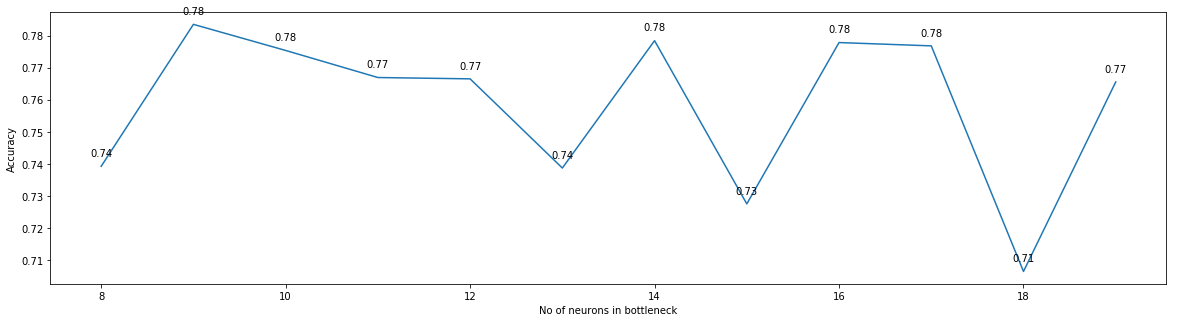

In [103]:
x_axis=list(range(8,20,1))
y_axis=accuracies
plt.figure(figsize=(20,5))
plt.plot(x_axis,y_axis)
plt.xlabel("No of neurons in bottleneck")
plt.ylabel("Accuracy")
for i,j in zip(x_axis,y_axis):
    label="{:.2f}".format(j)
    plt.annotate(label,
                (i,j),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
plt.show()

In [104]:
index=0
ma=-9999
for i in range(len(accuracies)):
    if accuracies[i] > ma:
        ma=accuracies[i]
        index=i
print(index)
print("maximum Accuracy occured at ",8+index ,"neurons in bottle neck with accuracy of ",ma)

1
maximum Accuracy occured at  9 neurons in bottle neck with accuracy of  0.78351066414031


In [105]:
testing_set_predictions=np.array(testing_set_predictions)
testing_set_predictions=testing_set_predictions.reshape(-1,)
testing_set_predictions.shape

(82332,)

## Evaluation
To evaluate the model we calculate the following performance metrics :
- Accuracy
- Recall
- Precision
- F1 Score
- Detection rate for each of the five possible labels

In [106]:
accuracy=accuracy_score(y0_test,testing_set_predictions)
recall=recall_score(y0_test,testing_set_predictions)
precision=precision_score(y0_test,testing_set_predictions)
f1=f1_score(y0_test,testing_set_predictions)
print("Performance over the testing data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}\n".format(accuracy,recall,precision,f1 ))

#


for class_ in classes:
    print(class_+" Detection Rate : {}".format(len(np.where(np.logical_and(testing_set_predictions==1 , y_test==class_))[0])/len(np.where(y_test==class_)[0])))


Performance over the testing data set 

Accuracy : 0.78351066414031 , Recall : 0.8072002117709345 , Precision : 0.8011209387862335 , F1 : 0.8041490857946555

Normal Detection Rate : 0.24551351351351353
Combined_attacks Detection Rate : 0.7824019024970273
DoS Detection Rate : 0.9068231841526045
Exploits Detection Rate : 0.8235716852317643
Fuzzers Detection Rate : 0.3719894424282415
Reconnaissance Detection Rate : 0.43907322654462244
Generic Detection Rate : 0.9861692544115309


The results performs well and is stable across many test runs and it outperforms many other approaches including other approaches we attempted as part of our study.

The following section plots the confusion matrix, the `plot_confusion_matrix` helper function was adapted from the __[scikit-learn library documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)__.

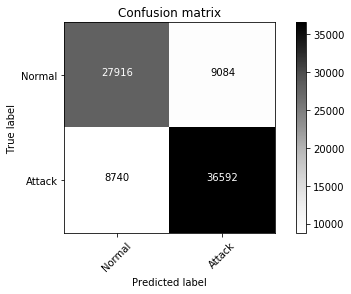

In [107]:
#Plotting confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
c = confusion_matrix(y0_test,testing_set_predictions)
plot_confusion_matrix(c,["Normal","Attack"])


The following violin plot shows the distribution of reconstruction loss values for all data samples in the testing set, it clearly shows that the  loss values of attacks are mostly higher then the threshold value, the opposite is true for normal samples.

In [108]:
autoencoders[index].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 195)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 195)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 9)                 1764      
_________________________________________________________________
dense_100 (Dense)            (None, 195)               1950      
Total params: 3,714
Trainable params: 3,714
Non-trainable params: 0
_________________________________________________________________


In [109]:
reduced_models[index].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 195)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 195)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 9)                 1764      
Total params: 1,764
Trainable params: 1,764
Non-trainable params: 0
_________________________________________________________________


In [110]:
x

array([[0.00000000e+00, 2.02463448e-03, 5.26814877e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.14064104e-05, 1.08317061e-02, 1.36971868e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.28128208e-05, 2.70521653e-02, 7.37540828e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.99977187e-01, 9.78018354e-01, 5.37351175e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99988594e-01, 1.45101749e-02, 9.48266779e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.18409900e-02, 9.48266779e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [111]:
dummy=reduced_models[index].predict(x)
dummy2=reduced_models[index].predict(x_test)

In [112]:
newcols=[
    'Feature_1',
    'Feature_2',
    'Feature_3',
    'Feature_4',
    'Feature_5',
    'Feature_6',
    'Feature_7',
    'Feature_8',
    'Feature_9'
]

In [113]:
dummy=pd.DataFrame(dummy,columns=newcols)
test=pd.DataFrame(dummy2,columns=newcols)

In [114]:
print(dummy.shape)
print(type(dummy))
print(test.shape)

(175342, 9)
<class 'pandas.core.frame.DataFrame'>
(82332, 9)


In [115]:
dummy.head(5)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
0,0.049657,0.035926,0.026128,0.030767,0.052902,-0.0,0.011015,0.068938,-0.000000
1,0.040672,0.059160,0.000844,0.028324,0.026038,-0.0,0.024361,0.067900,-0.000000
2,0.018073,0.058628,-0.000000,-0.000000,0.034784,-0.0,-0.000000,0.072701,-0.000000
3,0.067948,0.030660,0.039915,-0.000000,0.032733,-0.0,-0.000000,-0.000000,0.001613
4,0.170677,0.095014,-0.000000,-0.000000,0.040430,-0.0,-0.000000,0.067111,-0.000000


In [116]:
test.head(5)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
0,0.075569,-0.0,-0.0,-0.0,-0.0,0.177792,0.111175,0.073624,-0.0
1,0.109410,-0.0,-0.0,-0.0,-0.0,0.169645,0.135176,0.062456,-0.0
2,0.100458,-0.0,-0.0,-0.0,-0.0,0.172800,0.142730,0.070392,-0.0
3,0.095968,-0.0,-0.0,-0.0,-0.0,0.173897,0.133739,0.069112,-0.0
4,0.120948,-0.0,-0.0,-0.0,-0.0,0.166738,0.134930,0.056138,-0.0


In [117]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
# Create a decision tree classifier. By convention, clf means 'classifier'
clf = DecisionTreeClassifier(random_state=0)
clf.fit(dummy,y0)
Y_PRE=clf.predict(test)

#RESULTS
print("Accuracy  :",accuracy_score(y0_test,Y_PRE)*100)
print("Precision :",precision_score(y0_test,Y_PRE))
print("Recall   :",recall_score(y0_test,Y_PRE))
print("confusion matrix : \n",confusion_matrix(y0_test,Y_PRE))

Accuracy  : 80.89321284555216
Precision : 0.8024151529392534
Recall   : 0.8662975381628871
confusion matrix : 
 [[27330  9670]
 [ 6061 39271]]


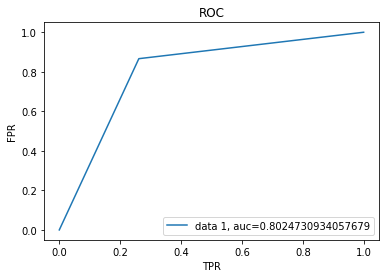

In [119]:
fpr, tpr, _ = metrics.roc_curve(y0_test,  Y_PRE)
auc = metrics.roc_auc_score(y0_test, Y_PRE)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC")
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.show()